# Coherence Theoretical Modeling

$$
\gamma_{total} = \gamma_{thermal}\gamma_{geom}\gamma_{temporal}\gamma_{processing}
$$

$\gamma_{processing}$ is assumed constant between Uavsar interferograms and is not evaluated (unless Ron gets back to me)

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import gamma
from scipy.special import hyp2f1
import xarray as xa

## P_Thermal - from Jung et al 2016

$$
p_{thermal} = \frac{1}{1+snr}
$$

Using Noise Equivalent Sigma Zero:
From uavsar calibration - -40 db at 20 degrees to -47 db at 38 degrees to -32 db at 65 degrees


"Unfortunately, NESZ is mystifying to SAR users who are not familiar with the dB language of engineering. Many users are confused by NESZ values like -20 dB, which actually indicates a fractional level of 1%. That is, an NESZ of -20 dB means the noise level is 1% as strong as a reference reflection from an idealized metal sphere. An NESZ of -17 dB would means the noise level is 2% as strong as the reference." - from (https://iceye-ltd.github.io/product-documentation/5.0/OverviewOfSAR/noise/).

"In non-vegetated areasthe main driver of the coherence is the contribution due tothe SNR." - from (https://www.researchgate.net/publication/225005475_The_TanDEM-X_mission_Overview_and_interferometric_performance)

"The SNRs were estimated by dividing sigma zero (σ∘) by NESZ [25]. The minimum NESZ was approximately −23 dB in HH polarization of FBS and FBD modes [35]. The acquired dataset showed a high SNR for the forest and urban areas, specifically > 9, and a low SNR in the sea area, specifically < 5. The thermal decorrelation of the forest and urban areas was less than 0.13; thus, thermal noise may not have been the cause of the major decorrelation in those areas. However, the areas with a low SNR, such as the sea and rivers, are prone to thermal decorrelation. Therefore, areas consisting of sea were masked out, " - from (https://ieeexplore.ieee.org/document/7505618)

In [3]:
def calc_NESZ(theta):
    # this equation is intended to match data from (https://uavsar.jpl.nasa.gov/science/documents/uavsar_polcal_ieee.pdf)
    # but is only approximately right because they don't have coefficents...
    # incidence angle control is due to the fact that measured values are beta_naught
    # which has to be converted to sigma_naught by NESN = NEBN * sin(inc)
    # from https://www.intelligence-airbusds.com/files/pmedia/public/r465_9_tsxx-airbusds-tn-0049-radiometric_calculations_d1.pdf
    return 0.021 * (theta - 38)**2 - 47

def p_thermal(signal, t):
    NESZ = calc_NESZ(t)
    SNR = signal - NESZ # since in decibels
    return 1 / (1 + SNR**-1)
p_thermal_v = np.vectorize(p_thermal)

In [4]:
ds = xa.open_dataset('/Users/zachkeskinen/Documents/uavsar/data/dc_lidar/ds-lidar-us5.nc')
sigma_signal = np.linspace(10*np.log10(abs(ds['052_amp1_VV'][0].min().values)), 10*np.log10(abs(ds['052_amp1_VV'][0].max().values)), 50)
thetas = np.deg2rad(np.linspace(0, 90, 50))

Text(0.5, 1.0, '$\\gamma_{thermal}$ vs signal power and incidence angle')

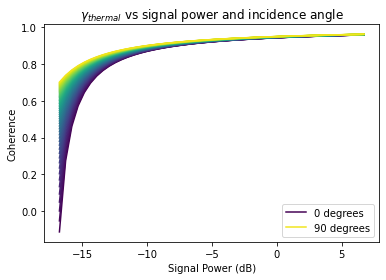

In [5]:
b = 10
for i, t in enumerate(thetas):
        if i == 0 or i == len(thetas) -1:
            plt.plot(sigma_signal, p_thermal_v(sigma_signal, t), color = mpl.colormaps['viridis'](i/len(thetas)), label = f'{np.rad2deg(t):.0f} degrees')
        else:
            plt.plot(sigma_signal, p_thermal_v(sigma_signal, t), color = mpl.colormaps['viridis'](i/len(thetas)), label = f'_{t:.2e}')
plt.legend()
plt.xlabel('Signal Power (dB)')
plt.ylabel('Coherence')
plt.title('$\gamma_{thermal}$ vs signal power and incidence angle')

Text(0, 0.5, 'Amplitude (dB)')

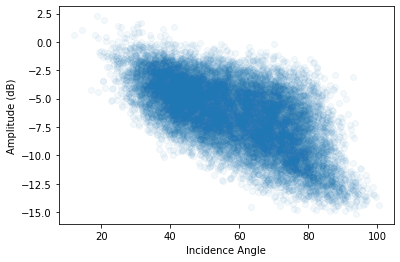

In [6]:
plt.scatter(np.rad2deg(ds['052_inc'].values.ravel()[::200]) , 10*np.log10((ds['052_amp1_VV'].values.ravel()[::200])), alpha = 0.05)
plt.xlabel('Incidence Angle')
plt.ylabel('Amplitude (dB)')

## P_Spatial - from Zebker and Villasenor (1992)

$$
p_{spatial} = 1 - \frac{2* |B| * R_{y} cos^{2} \theta }{\lambda r}
$$

where $B$ is the spatial baseline (varied over 0 to 20 meters), $R_{Y}$ is the range resolution (2 m for Uavsar), $\theta$ is averaged incidence angle (varied over 0 to 90), $\lambda$ is the wavelength (0.23 m for Uavsar), and r is the sensor to position distance (varied over )

In [7]:
def p_spatial(B, Ry, theta, r, lambda_ = 0.2379):
    return 1 - (2*np.abs(B)*Ry*np.cos(theta)**2)/(lambda_*r)
p_spatial_v = np.vectorize(p_spatial)

In [8]:
x = np.fromfile('/Users/zachkeskinen/Downloads/lowman_05208_01_BU_s1_2x8.lkv', dtype = np.dtype('<f'))[::3]
y = np.fromfile('/Users/zachkeskinen/Downloads/lowman_05208_01_BU_s1_2x8.lkv', dtype = np.dtype('<f'))[1::3]
z = np.fromfile('/Users/zachkeskinen/Downloads/lowman_05208_01_BU_s1_2x8.lkv', dtype = np.dtype('<f'))[2::3]
mag = (x**2 + y**2 + z**2)**0.5
print(f'Varying distances from {mag.min():.0f} to {mag.max():.0f} m')

## or theoretical distances from (https://uavsar.jpl.nasa.gov/science/documents/uavsar_polcal_ieee.pdf)
h = 12.5e3
angles = np.deg2rad([25, 65])
mag = h/np.cos(angles)
print(f'Varying distances theoretically from {mag[0]:.0f} to {mag[1]:.0f} m')

Varying distances from 12248 to 28735 m
Varying distances theoretically from 13792 to 29578 m


In [9]:
Bs = np.linspace(0.1, 20, 50)
Ry = 2.33
thetas = np.deg2rad(np.linspace(0, 90, 50))
lambda_uavsar = 0.2379
rs = np.linspace(12e3, 30e3, 50)

In [10]:
vary_b = p_spatial_v(Bs, Ry, theta = np.deg2rad(10), r = 30e3)
vary_t = p_spatial_v(20, Ry, theta = thetas, r = 30e3)
vary_r = p_spatial_v(20, Ry, theta = np.deg2rad(10), r = rs)

Text(0.5, 1.0, '$\\gamma_{geom}$ vs target range and incidence angle')

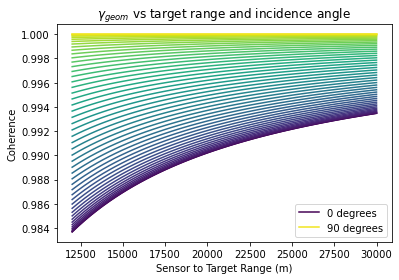

In [11]:
b = 10
for i, t in enumerate(thetas):
        if i == 0 or i == len(thetas) -1:
            plt.plot(rs, p_spatial_v(B = b, Ry = Ry, theta = t, r = rs), color = mpl.colormaps['viridis'](i/len(thetas)), label = f'{np.rad2deg(t):.0f} degrees')
        else:
            plt.plot(rs, p_spatial_v(B = b, Ry = Ry, theta = t, r = rs), color = mpl.colormaps['viridis'](i/len(thetas)), label = f'_{t:.2e}')
plt.legend()
plt.xlabel('Sensor to Target Range (m)')
plt.ylabel('Coherence')
plt.title('$\gamma_{geom}$ vs target range and incidence angle')

Text(0.5, 1.0, '$\\gamma_{geom}$ vs spatial baseline and incidence angle')

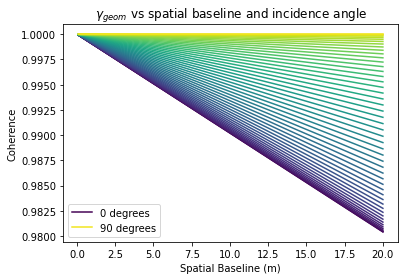

In [12]:
b = 10
for i, t in enumerate(thetas):
        if i == 0 or i == len(thetas) -1:
            plt.plot(Bs, p_spatial_v(B = Bs, Ry = Ry, theta = t, r = 20e3), color = mpl.colormaps['viridis'](i/len(thetas)), label = f'{np.rad2deg(t):.0f} degrees')
        else:
            plt.plot(Bs, p_spatial_v(B = Bs, Ry = Ry, theta = t, r = 20e3), color = mpl.colormaps['viridis'](i/len(thetas)), label = f'_{t:.2e}')
plt.legend()
plt.xlabel('Spatial Baseline (m)')
plt.ylabel('Coherence')
plt.title('$\gamma_{geom}$ vs spatial baseline and incidence angle')

## Temporal Decorrelation - 

Overall model:

$$
\gamma_{temp} = \exp(- \frac{\triangle T}{\tau})
$$

where T is the time baseline and $\tau$ is the characterisitic time (days) over which coherence decreaseds by a factor of e.

From Rocca (2007)

- Brownian model:

$$
\frac{T}{\tau} = \frac{1}{M}
$$

where M: 
$$
M = \frac{\tau}{T} = \frac{2}{T \sigma_Bd^2} (\frac{\lambda}{4 \pi})^2
$$

where $\sigma_Bd^2$ is the variance of brownian motion in the look direction in a day.

- Markov/Exponential Model:
scatterers split into those that are unchanged and those that have completely changed.
Cohernece is proportional to percentage of unchanged scatterers.

$$
\gamma_{temp}(t) = \frac{E[N_un(t)]}{N_total}
$$

where $N_un(t)$ is the number of unchanged scatteres as a function of time.
the $\tau$ of the elemental scatterers may be different and be bi-modal or tri-modal.


In [13]:
def temp_model(T, tau):
    return np.exp(- T / tau)
temp_model_v = np.vectorize(temp_model)

In [14]:
T = np.linspace(0, 300, 100)
tau = 

SyntaxError: invalid syntax (3223396743.py, line 2)

from Zebker and Villasenor (1992)

$$
p_{temporal} = exp(- \frac{1}{2} (\frac{4 \pi}{\lambda})^{2} (\sigma_{y}^{2} \sin^{2}(\theta) + \sigma_{z}^{2} \cos^{2}(\theta))
$$

where $\sigma_{y}$ is the standard deviation of movement in the horizontal direction. where $\sigma_{z}$ is the standard deviation of movement in the vertical direction.

#### Notes from Zebker and Villasenor:

for incidence angle less than 45 degrees changes in vertical leads to larger loses in coherence than horizontal shifts and vice versa

For L-Band: 10 cm of rms gaussian motion leads to total decorrelation

In [ ]:
def p_temporal(sigma_y, sigma_z, theta, lambda_ = 0.2379):
    return np.exp(-1/2*(4*np.pi/lambda_)**2 * (sigma_y**2 * np.sin(theta)**2 + sigma_z**2 * np.cos(theta)**2))
p_temporal_v = np.vectorize(p_temporal)

In [ ]:
sigma_y = np.linspace(0, 0.1, 100)
sigma_z = np.linspace(0, 0.1, 100)

In [ ]:
vary_y = p_temporal_v(sigma_y = sigma_y, sigma_z = 0.01, theta = np.deg2rad(45))
vary_z = p_temporal_v(sigma_y = 0.01, sigma_z = sigma_z, theta = np.deg2rad(45))

Text(0.5, 1.0, '$\\gamma_{temporal}$ vs horizontal scatterer movement and incidence angle')

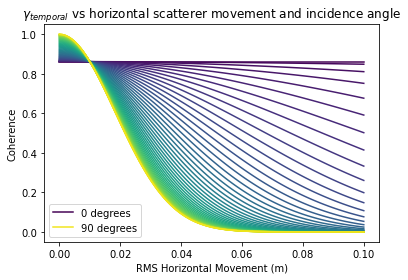

In [ ]:
z_rms = 0.01
for i, t in enumerate(thetas):
        if i == 0 or i == len(thetas) -1:
            plt.plot(sigma_y, p_temporal_v(sigma_y = sigma_y, sigma_z = z_rms, theta = t), color = mpl.colormaps['viridis'](i/len(thetas)), label = f'{np.rad2deg(t):.0f} degrees')
        else:
            plt.plot(sigma_y, p_temporal_v(sigma_y = sigma_y, sigma_z = z_rms, theta = t), color = mpl.colormaps['viridis'](i/len(thetas)))
plt.legend()
plt.xlabel('RMS Horizontal Movement (m)')
plt.ylabel('Coherence')
plt.title('$\gamma_{temporal}$ vs horizontal scatterer movement and incidence angle')

Text(0.5, 1.0, '$\\gamma_{temporal}$ vs vertical scatterer movement and incidence angle')

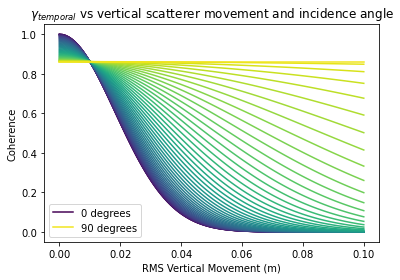

In [ ]:
y_rms = 0.01
for i, t in enumerate(thetas):
        if i == 0 or i == len(thetas) -1:
            plt.plot(sigma_z, p_temporal_v(sigma_y = y_rms, sigma_z = sigma_z, theta = t), color = mpl.colormaps['viridis'](i/len(thetas)), label = f'{np.rad2deg(t):.0f} degrees')
        else:
            plt.plot(sigma_z, p_temporal_v(sigma_y = y_rms, sigma_z = sigma_z, theta = t), color = mpl.colormaps['viridis'](i/len(thetas)))
plt.legend()
plt.xlabel('RMS Vertical Movement (m)')
plt.ylabel('Coherence')
plt.title('$\gamma_{temporal}$ vs vertical scatterer movement and incidence angle')

## Snow wetness coherence loss

- https://www.sciencedirect.com/science/article/pii/S0034425715001418 - section 3.4

In [ ]:
def calc_snow_permittivity(density, water_vol = 0):
    ## from Tiuri et al (1984)
    # https://www.researchgate.net/publication/263579827_The_complex_dielectric_constant_of_snow_at_microwave_frequencies
    # at 1 GHz

    if np.any(density > 1):
        # convert density to relative to water
        density = density / 997


    perm_real = 1 + 1.7 * density + 0.7 * density **2
    perm_imag = (0.52*density + 0.62 * density **2) * 8e-4
    if water_vol > 0:
        perm_real = perm_real + 8.9 * water_vol + 70 * water_vol **2
        perm_imag = 0.9 * water_vol + 7.2 * water_vol**2
    return perm_real + perm_imag*1j
calc_snow_permittivity = np.vectorize(calc_snow_permittivity)
def reflectivity(perm):
    ref = np.abs((np.sqrt(perm) - 1)/ (np.sqrt(perm) + 1))**2
    # tran = 1 - ref
    return ref

def exponential_decay(perm, radar_lambda = 0.23):
    alpha = 2 * np.pi / radar_lambda * np.abs(np.sqrt(perm).imag)
    return alpha

def penetration_depth(alpha, theta = 0):
    depth = np.cos(theta) / (2*alpha)
    return depth


# recreate figures from papers to test formulas

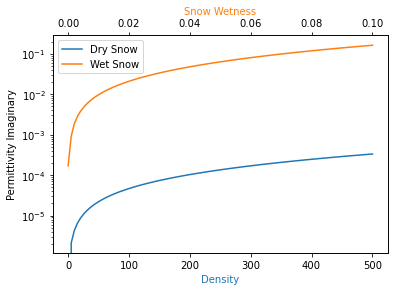

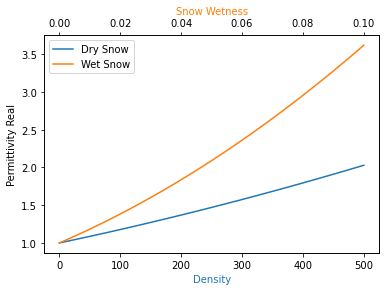

In [ ]:
pd= np.linspace(0, 500, 100)
es_i = calc_snow_permittivity(pd)#/(8e-4) # divide by imaginary permitivity of water to match figure
plt.plot(pd, es_i.imag, label = 'Dry Snow')
ax = plt.gca()
ax2 = plt.twiny(ax)

wv = np.linspace(0,0.1, 100)
es_i = calc_snow_permittivity(density = 300, water_vol = wv)
ax2.plot(wv, es_i.imag, label = 'Wet Snow', color = 'C1')
ax.set_xlabel('Density', color = 'C0')
ax2.set_xlabel('Snow Wetness', color = 'C1')
ax.set_ylabel('Permittivity Imaginary')
ax.set_yscale('log')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

pd= np.linspace(0, 500, 100)
es_i = calc_snow_permittivity(pd)#/(8e-4) # divide by imaginary permitivity of water to match figure
plt.plot(pd, es_i.real, label = 'Dry Snow')
ax = plt.gca()
ax2 = plt.twiny(ax)

wv = np.linspace(0,0.1, 100)
es_i = calc_snow_permittivity(density = pd, water_vol = wv)# - calc_snow_permittivity(density= pd) # subtract dry snow amount to match figure
ax2.plot(wv, es_i.real, label = 'Wet Snow', color = 'C1')
ax.set_xlabel('Density', color = 'C0')
ax2.set_xlabel('Snow Wetness', color = 'C1')
ax.set_ylabel('Permittivity Real')
# ax.set_yscale('log')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

/var/folders/0n/swn__wf94qd3zdch1tvp087r0000gn/T/ipykernel_29437/3337045972.py:28: RuntimeWarning: divide by zero encountered in true_divide
  depth = np.cos(theta) / (2*alpha)


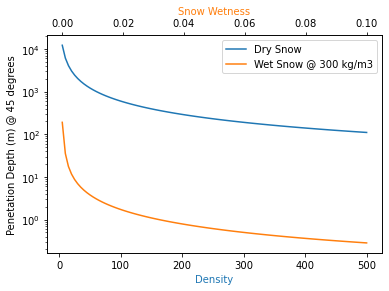

In [ ]:
# matching Ulaby et al (1996)
density = np.linspace(0, 500, 100)
volumetic_content = np.linspace(0, 0.1, 100)
thetas = np.linspace(np.deg2rad(0), np.deg2rad(90), 100)

es_s = calc_snow_permittivity(density)#/(8e-4) # divide by imaginary permitivity of water to match figure
alphas = exponential_decay(es_s)
pen_depths = penetration_depth(alphas, theta = np.deg2rad(45))
plt.plot(pd, pen_depths, label = 'Dry Snow')
ax = plt.gca()
ax2 = plt.twiny(ax)

wv = np.linspace(0,0.1, 100)
es_s = calc_snow_permittivity(density = 300, water_vol = wv)
alphas = exponential_decay(es_s)
pen_depths = penetration_depth(alphas, theta = np.deg2rad(45))
ax2.plot(wv, pen_depths, label = 'Wet Snow @ 300 kg/m3', color = 'C1')

ax.set_xlabel('Density', color = 'C0')
ax2.set_xlabel('Snow Wetness', color = 'C1')
ax.set_ylabel('Penetation Depth (m) @ 45 degrees')
ax.set_yscale('log')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

# amplitude reductions for snow depths and wetness

Text(0.5, 0, 'Snow Depth')

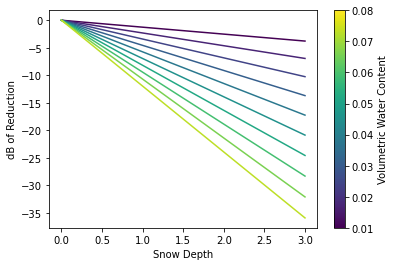

In [ ]:
snow_depths = np.linspace(0, 3, 100)
volumetic_content = np.linspace(0.01, 0.08, 10)

def power_reduction(depth, pen_depth):
    return 1/np.e**(depth/pen_depth)

for i, vc in enumerate(volumetic_content):
    e = calc_snow_permittivity(density = 300, water_vol = vc)
    alpha = exponential_decay(e)
    pen_depth = penetration_depth(alpha, theta = np.deg2rad(45))
    prs = power_reduction(snow_depths, pen_depth)
    prs_db = 10*np.log10(prs)

    c = mpl.colormaps['viridis'](i/len(volumetic_content))
    plt.plot(snow_depths, prs_db, color = c)
sm = plt.cm.ScalarMappable(cmap=mpl.colormaps['viridis'], norm=plt.Normalize(vmin=volumetic_content[0], vmax=volumetic_content[-1]))
plt.colorbar(sm, label = 'Volumetric Water Content')
plt.ylabel('dB of Reduction')
plt.xlabel('Snow Depth')

# Fraunhofer Criteria

From Ulaby volume 2:
discriminating between rough and smooth surfaces in microwave frequencies:

$$
\sigma < \frac{\lambda}{32 * \cos(\theta)}
$$

Where if sigma is below that threshold it is considered smooth and above is considered rough.

Text(0, 0.5, 'Standard Deviation of Height (cm)')

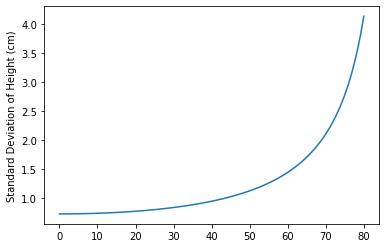

In [18]:
lambda_radar = 0.23
thetas = np.deg2rad(np.linspace(0, 80, 100))
standard_dev_h = lambda_radar / (32 * np.cos(thetas))
plt.plot(np.rad2deg(thetas), standard_dev_h*100)
plt.ylabel('Standard Deviation of Height (cm)')

## Decomposing $\gamma_{temporal} into ground and volume - from Jung et al (2016)

Overall model:

$$
\gamma_{temp} = exp(- \frac{\triangle T}{\tau})
$$

is decomposed into 

1. motion of scatters:

$$
\gamma_{motion} = \exp(-\frac{1}{2} (\frac{4 \pi}{\lambda} \sigma_{\xi}))
$$

where $\sigma_{\xi}$ is the standard deviation of movement of the volume

2. the temporally correlated dielectric changes in volume and ground 

$$
\gamma_{di, time-correlated, ground} = \exp(- \frac{\triangle T}{\tau_{ground}})
$$
$$
\gamma_{di, time-correlated, volume} = \exp(- \frac{\triangle T}{\tau_{volume}})
$$

3. the uncorrelated in time dielectric changes in volume and ground $\gamma_{di, rand, volume}$ and $\gamma_{di, rand, ground}$.

With the random dielectric and volume movement terms collapsing into one term.

The ground to volume effects on coherence are controlled by $\mu$ or ground to volume ratio in the sar echo.

# Jung et al continued

Next they found areas of high coherence over a whole time series and assumed these areas have relatively small decorrelation from $\gamma_{movement}$, $\gamma_{di, vol, rand}$ and $\gamma_{di, ground, rand}$. Ie those terms were almost 1. This led to the simplification:

$$
\gamma_t^{high} = \frac{1}{1+\mu} * exp(- \frac{\triangle T}{\tau_v}) + \frac{\mu}{1+\mu} * exp(- \frac{\triangle T}{\tau_g})
$$

Can we used areas with no trees to get : snow-free (mostly ground contribution) and snow (some volume contribution)

They curve fit a line that matched the highest coherence points vs temporal baseline as any reduction is probably due to drops in random or dielectric coherence terms.

Use man made structures and forests to define volumetric coherence and tau_g vs tau_v

In [235]:
def gamma_t_high(T, u, tau_v, tau_g):
    gamma_t_v = (1/(1+u)) * np.exp(- T / tau_v)
    gamma_t_g = (u/(1+u)) * np.exp(- T / tau_g)
    return gamma_t_v + gamma_t_g
gamma_t_high_v = np.vectorize(gamma_t_high)

In [256]:
# values from extremes of Jung et al
us = np.linspace(0.5, 10, 100)
tau_gs = np.linspace(600, 3000, 100)
tau_vs = np.linspace(45, 150, 100)
Ts = np.linspace(0, 300, 100)

params = {'bare-ground': [9.42, 2888, 77], 'evergreen': [0.53, 1219, 49], 'man-made-structure': [9.89, 6313, 52], 'everygreen-2':[4.05, 627, 142]}

Text(0.5, 1.0, '$\\gamma_{temporal}$ vs temporal baseline for material parameterization')

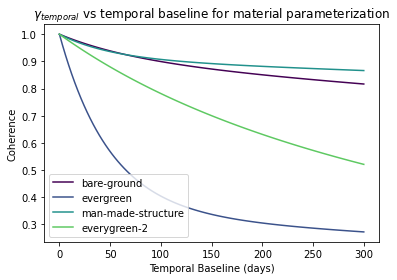

In [262]:
for i, (n, (u, tau_g, tau_v)) in enumerate(params.items()):
            plt.plot(Ts, gamma_t_high_v(T = Ts, u = u, tau_v = tau_v, tau_g = tau_g), color = mpl.colormaps['viridis'](i/len(params)), label = n)
        # else:
        #     plt.plot(Ts, gamma_t_high_v(T = Ts, u = 9.43, tau_v = tau_v, tau_g = tau_g), color = mpl.colormaps['viridis'](i/len(params)))
plt.legend(loc = 'lower left')
plt.xlabel('Temporal Baseline (days)')
plt.ylabel('Coherence')
plt.title('$\gamma_{temporal}$ vs temporal baseline for material parameterization')

## Phase Errors from coherence and number of looks

Lee et al (1994) - https://iopscience.iop.org/article/10.1088/0959-7174/4/3/006/pdf - equation 20

$$
p(\triangle \phi) = \frac{\Gamma (N + 0.5) (1 - |\gamma|^{2})^{N} |\gamma| cos(\triangle \phi)} {(2 \sqrt{\pi}) \Gamma (N) ( 1- |\gamma|^{2} \cos^{2}(\triangle \phi))^{N+0.5}} + \frac{(1- |\gamma|^{2})^{N}}{2\pi} _{2}F_{1} (N, 1; 0.5l |\gamma|^{2} cos^{2}(\triangle \phi))
$$

where $\triangle \phi$ is the intereometric phase error